In [1]:
import torch
import torchvision
import numpy as np
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,ConcatDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
#credit to 'https://github.com/gidariss/FeatureLearningRotNet/blob/master/architectures/NetworkInNetwork.py'
#NIN model
import math

class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super(BasicBlock, self).__init__()
        padding = (kernel_size - 1) // 2
        self.layers = nn.Sequential()
        self.layers.add_module('Conv', nn.Conv2d(in_planes, out_planes,
                                                 kernel_size=kernel_size, stride=1, padding=padding, bias=False))
        self.layers.add_module('BatchNorm', nn.BatchNorm2d(out_planes))
        self.layers.add_module('ReLU', nn.ReLU(inplace=True))

    def forward(self, x):
        return self.layers(x)

class GlobalAveragePooling(nn.Module):
    def __init__(self):
        super(GlobalAveragePooling, self).__init__()

    def forward(self, feat):
        num_channels = feat.size(1)
        return F.avg_pool2d(feat, (feat.size(2), feat.size(3))).view(-1, num_channels)

class NetworkInNetwork(nn.Module):
    def __init__(self, opt):
        super(NetworkInNetwork, self).__init__()

        num_classes = opt['num_classes']
        num_inchannels = opt['num_inchannels'] if ('num_inchannels' in opt) else 3
        num_stages = opt['num_stages'] if ('num_stages' in opt) else 3
        use_avg_on_conv3 = opt['use_avg_on_conv3'] if ('use_avg_on_conv3' in opt) else True

        assert(num_stages >= 3)
        nChannels = 192
        nChannels2 = 160
        nChannels3 = 96

        blocks = [nn.Sequential() for _ in range(num_stages)]
        # 1st block
        blocks[0].add_module('Block1_ConvB1', BasicBlock(num_inchannels, nChannels, 5))
        blocks[0].add_module('Block1_ConvB2', BasicBlock(nChannels, nChannels2, 1))
        blocks[0].add_module('Block1_ConvB3', BasicBlock(nChannels2, nChannels3, 1))
        blocks[0].add_module('Block1_MaxPool', nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        # 2nd block
        blocks[1].add_module('Block2_ConvB1', BasicBlock(nChannels3, nChannels, 5))
        blocks[1].add_module('Block2_ConvB2', BasicBlock(nChannels, nChannels, 1))
        blocks[1].add_module('Block2_ConvB3', BasicBlock(nChannels, nChannels, 1))
        blocks[1].add_module('Block2_AvgPool', nn.AvgPool2d(kernel_size=3, stride=2, padding=1))

        # 3rd block
        blocks[2].add_module('Block3_ConvB1', BasicBlock(nChannels, nChannels, 3))
        blocks[2].add_module('Block3_ConvB2', BasicBlock(nChannels, nChannels, 1))
        blocks[2].add_module('Block3_ConvB3', BasicBlock(nChannels, nChannels, 1))

        if num_stages > 3 and use_avg_on_conv3:
            blocks[2].add_module('Block3_AvgPool', nn.AvgPool2d(kernel_size=3, stride=2, padding=1))

        for s in range(3, num_stages):
            blocks[s].add_module('Block'+str(s+1)+'_ConvB1', BasicBlock(nChannels, nChannels, 3))
            blocks[s].add_module('Block'+str(s+1)+'_ConvB2', BasicBlock(nChannels, nChannels, 1))
            blocks[s].add_module('Block'+str(s+1)+'_ConvB3', BasicBlock(nChannels, nChannels, 1))

        # global average pooling and classifier
        blocks.append(nn.Sequential())
        blocks[-1].add_module('GlobalAveragePooling', GlobalAveragePooling())
        blocks[-1].add_module('Classifier', nn.Linear(nChannels, num_classes))

        self._feature_blocks = nn.ModuleList(blocks)
        self.all_feat_names = ['conv'+str(s+1) for s in range(num_stages)] + ['classifier',]
        assert(len(self.all_feat_names) == len(self._feature_blocks))

    def _parse_out_keys_arg(self, out_feat_keys):
        # By default return the features of the last layer / module.
        out_feat_keys = [self.all_feat_names[-1],] if out_feat_keys is None else out_feat_keys

        if len(out_feat_keys) == 0:
            raise ValueError('Empty list of output feature keys.')

        for f, key in enumerate(out_feat_keys):
            if key not in self.all_feat_names:
                raise ValueError('Feature with name {0} does not exist. Existing features: {1}.'.format(key, self.all_feat_names))
            elif key in out_feat_keys[:f]:
                raise ValueError('Duplicate output feature key: {0}.'.format(key))

        # Find the highest output feature in `out_feat_keys
        max_out_feat = max([self.all_feat_names.index(key) for key in out_feat_keys])

        return out_feat_keys, max_out_feat

    def forward(self, x, out_feat_keys=None):
        """Forward an image `x` through the network and return the asked output features.

        Args:
          x: input image.
          out_feat_keys: a list/tuple with the feature names of the features
                that the function should return. By default the last feature of
                the network is returned.

        Return:
            out_feats: If multiple output features were asked then `out_feats`
                is a list with the asked output features placed in the same
                order as in `out_feat_keys`. If a single output feature was
                asked then `out_feats` is that output feature (and not a list).
        """
        out_feat_keys, max_out_feat = self._parse_out_keys_arg(out_feat_keys)
        out_feats = [None] * len(out_feat_keys)

        feat = x
        for f in range(max_out_feat + 1):
            feat = self._feature_blocks[f](feat)
            key = self.all_feat_names[f]
            if key in out_feat_keys:
                out_feats[out_feat_keys.index(key)] = feat

        out_feats = out_feats[0] if len(out_feats) == 1 else out_feats
        return out_feats

    def weight_initialization(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m.weight.requires_grad:
                    n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                if m.weight.requires_grad:
                    m.weight.data.fill_(1)
                if m.bias.requires_grad:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                if m.bias.requires_grad:
                    m.bias.data.zero_()

def create_model(opt):
    return NetworkInNetwork(opt)

if __name__ == '__main__':
    size = 32
    opt = {'num_classes': 4, 'num_stages': 4}

    net = create_model(opt)
    x = torch.autograd.Variable(torch.FloatTensor(1, 3, size, size).uniform_(-1, 1))

    out = net(x, out_feat_keys=net.all_feat_names)
    for f in range(len(out)):
        print('Output feature {0} - size {1}'.format(
            net.all_feat_names[f], out[f].size()))

    out = net(x)
    print('Final output: {0}'.format(out.size()))

Output feature conv1 - size torch.Size([1, 96, 16, 16])
Output feature conv2 - size torch.Size([1, 192, 8, 8])
Output feature conv3 - size torch.Size([1, 192, 4, 4])
Output feature conv4 - size torch.Size([1, 192, 4, 4])
Output feature classifier - size torch.Size([1, 4])
Final output: torch.Size([1, 4])


In [12]:
#credit to 'https://github.com/gidariss/FeatureLearningRotNet/blob/master/architectures/LinearClassifier.py'
#linear classifier
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, feat):
        return feat.view(feat.size(0), -1)
class Classifier(nn.Module):
    def __init__(self, opt):
        super(Classifier, self).__init__()
        nChannels = opt['nChannels']
        num_classes = opt['num_classes']
        pool_size = opt['pool_size']
        pool_type = opt['pool_type'] if ('pool_type' in opt) else 'max'
        nChannelsAll = nChannels * pool_size * pool_size

        self.classifier = nn.Sequential()
        if pool_type == 'max':
            self.classifier.add_module('MaxPool', nn.AdaptiveMaxPool2d((pool_size, pool_size)))
        elif pool_type == 'avg':
            self.classifier.add_module('AvgPool', nn.AdaptiveAvgPool2d((pool_size, pool_size)))
        self.classifier.add_module('BatchNorm', nn.BatchNorm2d(nChannels, affine=False))
        self.classifier.add_module('Flatten', Flatten())
        self.classifier.add_module('LinearClassifier', nn.Linear(nChannelsAll, num_classes))
        self.initialize()

    def forward(self, feat):
        return self.classifier(feat)

    def initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                fin = m.in_features
                fout = m.out_features
                std_val = np.sqrt(2.0 / fout)
                m.weight.data.normal_(0.0, std_val)
                if m.bias is not None:
                    m.bias.data.fill_(0.0)

In [13]:

#conv classifier
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1):
        super(BasicBlock, self).__init__()
        padding = (kernel_size - 1) // 2
        self.layers = nn.Sequential()
        self.layers.add_module('Conv', nn.Conv2d(in_planes, out_planes,
                                                 kernel_size=kernel_size, stride=stride, padding=padding, bias=False))
        self.layers.add_module('BatchNorm', nn.BatchNorm2d(out_planes))
        self.layers.add_module('ReLU', nn.ReLU(inplace=True))

    def forward(self, x):
        return self.layers(x)

class GlobalAvgPool(nn.Module):
    def __init__(self):
        super(GlobalAvgPool, self).__init__()

    def forward(self, feat):
        assert(feat.size(2) == feat.size(3))
        feat_avg = F.avg_pool2d(feat, feat.size(2)).view(-1, feat.size(1))
        return feat_avg

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, feat):
        return feat.view(feat.size(0), -1)

class Classifier(nn.Module):
    def __init__(self, opt):
        super(Classifier, self).__init__()
        nChannels = opt['nChannels']
        num_classes = opt['num_classes']
        self.cls_type = opt['cls_type']

        self.classifier = nn.Sequential()

        if self.cls_type == 'MultLayer':
            nFeats = min(num_classes*20, 2048)
            self.classifier.add_module('Flatten', Flatten())
            self.classifier.add_module('Linear_1', nn.Linear(nChannels, nFeats, bias=False))
            self.classifier.add_module('BatchNorm_1', nn.BatchNorm2d(nFeats))
            self.classifier.add_module('ReLU_1', nn.ReLU(inplace=True))
            self.classifier.add_module('Linear_2', nn.Linear(nFeats, nFeats, bias=False))
            self.classifier.add_module('BatchNorm2d', nn.BatchNorm2d(nFeats))
            self.classifier.add_module('ReLU_2', nn.ReLU(inplace=True))
            self.classifier.add_module('Linear_F', nn.Linear(nFeats, num_classes))
        elif self.cls_type == 'NIN_ConvBlock3':
            self.classifier.add_module('Block3_ConvB1', BasicBlock(nChannels, 192, 3))
            self.classifier.add_module('Block3_ConvB2', BasicBlock(192, 192, 1))
            self.classifier.add_module('Block3_ConvB3', BasicBlock(192, 192, 1))
            self.classifier.add_module('GlobalAvgPool', GlobalAvgPool())
            self.classifier.add_module('Linear_F', nn.Linear(192, num_classes))
        elif self.cls_type == 'Alexnet_conv5' or self.cls_type == 'Alexnet_conv4':
            if self.cls_type == 'Alexnet_conv4':
                block5 = nn.Sequential(
                    nn.Conv2d(256, 256, kernel_size=3, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(inplace=True),
                )
                self.classifier.add_module('ConvB5', block5)
            self.classifier.add_module('Pool5', nn.MaxPool2d(kernel_size=3, stride=2))
            self.classifier.add_module('Flatten', Flatten())
            self.classifier.add_module('Linear1', nn.Linear(256*6*6, 4096, bias=False))
            self.classifier.add_module('BatchNorm1', nn.BatchNorm1d(4096))
            self.classifier.add_module('ReLU1', nn.ReLU(inplace=True))
            self.classifier.add_module('Linear2', nn.Linear(4096, 4096, bias=False))
            self.classifier.add_module('BatchNorm2', nn.BatchNorm1d(4096))
            self.classifier.add_module('ReLU2', nn.ReLU(inplace=True))
            self.classifier.add_module('LinearF', nn.Linear(4096, num_classes))
        else:
            raise ValueError('Not recognized classifier type: %s' % self.cls_type)

        self.initialize()

    def forward(self, feat):
        return self.classifier(feat)

    def initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                fin = m.in_features
                fout = m.out_features
                std_val = np.sqrt(2.0/fout)
                m.weight.data.normal_(0.0, std_val)
                if m.bias is not None:
                    m.bias.data.fill_(0.0)

def create_model(opt):
    return Classifier(opt)

# Example usage:
# size = 32
# opt = {'num_classes': 10, 'nChannels': 3, 'cls_type': 'MultLayer'}
# net = create_model(opt)
# x = torch.autograd.Variable(torch.FloatTensor(1, 3, size, size).uniform_(-1, 1))
# out = net(x)
# print(out)


# cls_net_optim_params = {'optim_type': 'sgd', 'lr': 0.1, 'momentum':0.9, 'weight_decay': 5e-4, 'nesterov': True, 'LUT_lr':[(35, 0.1),(70, 0.02),(85, 0.004),(100, 0.0008)]}
# cls_net_opt = {'num_classes':10, 'nChannels':192, 'cls_type':'NIN_ConvBlock3'}

In [ ]:
#example of get the feature map generated by the pretrained model(2nd block)

NIN_net_4block = NetworkInNetwork({'num_classes': 4, 'num_stages': 4, 'use_avg_on_conv3': False})

# Load the state_dict using torch.load
checkpoint_path = '/content/NIN_net_4block.pth'
checkpoint = torch.load(checkpoint_path)

# Load the state_dict into the model
NIN_net_4block.load_state_dict(checkpoint)

out = NIN_net_4block(x, out_feat_keys=NIN_net_4block.all_feat_names)
for f in range(len(out)):
    print('Output feature {0} - size {1}'.format(
        NIN_net_4block.all_feat_names[f], out[f]))

In [19]:

out_feat_keys = ['conv2']  # Specify the desired feature key(s)

out = NIN_net_4block(x, out_feat_keys=out_feat_keys)

# Print the size of the desired feature(s)
for f in range(len(out)):
    print('Output feature {0} - size {1}'.format(
        out_feat_keys[f], out[f].shape))

Output feature conv2 - size torch.Size([192, 8, 8])


In [13]:
# Assuming NIN_net_4block and Classifier are already defined

# Set up the model and move it to the device  # or 'cpu' depending on your availability

NIN_net_4block.to(device)
classifier = Classifier({'num_classes': 10, 'nChannels': 192, 'cls_type': 'NIN_ConvBlock3'}).to(device)


# out_feat_keys = ['conv2']

# feature_map = NIN_net_4block(x, out_feat_keys=out_feat_keys)

# # Use the extracted feature map for classification
# classification_result = classifier(feature_map)

# # Print the classification result
# print('Classification result:', classification_result)


In [ ]:
# feature_map = NIN_net_4block(x, out_feat_keys=out_feat_keys)
# feature_map.shape

In [71]:

import torchvision
import torchvision.transforms as transforms

#############################################
# your code here
transform = transforms.Compose([
    transforms.RandomCrop(size = 32, padding=4),#random cropping
    transforms.RandomHorizontalFlip() ,#random flip
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# specify preprocessing function

transform_train = transform

transform_val = transform

from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

#############################################
# your code here

from torchvision.datasets import CIFAR10

# your code here
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

train_set = CIFAR10(
    root=DATA_ROOT,
    train=True,
    download=True,
    transform=transform_train
)

val_set = CIFAR10(
    root=DATA_ROOT,
    train=False,
    download=True,
    transform=transform_val
)

# construct dataloader
train_loader = DataLoader(
    dataset=train_set,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

val_loader = DataLoader(
    dataset=val_set,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=4
)


Files already downloaded and verified
Files already downloaded and verified


**random initialize + conv**


In [15]:
#hyperparameter setting
INITIAL_LR = 0.1
MOMENTUM = 0.9
REG = 5e-4
EPOCHS = 100
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(classifier.parameters(), lr = INITIAL_LR,
                      momentum = MOMENTUM,
                      weight_decay=REG)

In [16]:

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

DECAY = 0.2
valid_acc = []
losslist = []
print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    if i  == 30 or i == 60 or i == 80:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)

    classifier.train()

    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0
    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # inputs = inputs.to(device)
        inputs = inputs.to(device)
        feature_map = NIN_net_4block(inputs, out_feat_keys=out_feat_keys)
        targets = targets.to(device)
        NIN_net_4block = NIN_net_4block.to(device)
        # compute the output and loss
        outputs = classifier(feature_map)
        loss = criterion(outputs, targets)

        train_loss += loss
        # zero the gradient

        optimizer.zero_grad()
        # backpropagation

        loss.backward()
        # apply gradient and update the weights
        optimizer.step()
        # count the number of correctly predicted samples in the current batch
        _, predicted = outputs.max(1)  #make prediction based on the highest value
        total_examples += targets.size(0) # in this case,128 for each batch
        correct_examples += predicted.eq(targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))


    classifier.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            inputs = inputs.to(device)
            targets = targets.to(device)
            feature_map = NIN_net_4block(inputs, out_feat_keys=out_feat_keys)
            NIN_net_4block = NIN_net_4block.to(device)


            # compute the output and loss

            outputs = classifier(feature_map)
            loss = criterion(outputs, targets)
            val_loss += loss

            # count the number of correctly predicted samples in the current batch
            _, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += predicted.eq(targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    valid_acc.append(avg_acc)
    losslist.append(avg_loss.item())
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")

        torch.save(classifier.state_dict(), 'classifier_conv3_NIN_block2.pth')

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 1.5704, Training accuracy: 0.4399
Validation loss: 1.3744, Validation accuracy: 0.5030

Epoch 1:
Training loss: 1.2935, Training accuracy: 0.5370
Validation loss: 1.3538, Validation accuracy: 0.5139

Epoch 2:
Training loss: 1.2099, Training accuracy: 0.5671
Validation loss: 1.3084, Validation accuracy: 0.5333

Epoch 3:
Training loss: 1.1651, Training accuracy: 0.5842
Validation loss: 1.3662, Validation accuracy: 0.5196

Epoch 4:
Training loss: 1.1229, Training accuracy: 0.6000
Validation loss: 1.1910, Validation accuracy: 0.5790

Epoch 5:
Training loss: 1.0945, Training accuracy: 0.6127
Validation loss: 1.1419, Validation accuracy: 0.5938

Epoch 6:
Training loss: 1.0828, Training accuracy: 0.6166
Validation loss: 1.2562, Validation accuracy: 0.5696

Epoch 7:
Training loss: 1.0550, Training accuracy: 0.6263
Validation loss: 1.2309, Validation accuracy: 0.5752

Epoch 8:
Training loss: 1.0429, Training accuracy: 0.6303
Validation loss: 1.1248, 

In [ ]:
plt.plot(valid_acc)
plt.ylim(0.4,0.8)
plt.xlabel('num_epochs')
plt.ylabel('valid_acc')
plt.title('NIN_block2_conv3_classify_wholelabel')

In [31]:
#fc-layer + 2nb block feature map random init
NIN_net_4block.to(device)
out_feat_keys = ['conv1']
classifier = Classifier({'num_classes': 10, 'nChannels': 96, 'cls_type': 'NIN_ConvBlock3'}).to(device)
#hyperparameter setting
INITIAL_LR = 0.1
MOMENTUM = 0.9
REG = 5e-4
EPOCHS = 100
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(classifier.parameters(), lr = INITIAL_LR,
                      momentum = MOMENTUM,
                      weight_decay=REG)

In [33]:
# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

DECAY = 0.2
valid_acc_fc = []
losslist = []
print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    if i  == 30 or i == 60 or i == 80:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)

    classifier.train()

    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0
    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # inputs = inputs.to(device)
        inputs = inputs.to(device)
        feature_map = NIN_net_4block(inputs, out_feat_keys=out_feat_keys)
        targets = targets.to(device)
        NIN_net_4block = NIN_net_4block.to(device)
        # compute the output and loss
        outputs = classifier(feature_map)
        loss = criterion(outputs, targets)

        train_loss += loss
        # zero the gradient

        optimizer.zero_grad()
        # backpropagation

        loss.backward()
        # apply gradient and update the weights
        optimizer.step()
        # count the number of correctly predicted samples in the current batch
        _, predicted = outputs.max(1)  #make prediction based on the highest value
        total_examples += targets.size(0) # in this case,128 for each batch
        correct_examples += predicted.eq(targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))


    classifier.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            inputs = inputs.to(device)
            targets = targets.to(device)
            feature_map = NIN_net_4block(inputs, out_feat_keys=out_feat_keys)
            NIN_net_4block = NIN_net_4block.to(device)


            # compute the output and loss

            outputs = classifier(feature_map)
            loss = criterion(outputs, targets)
            val_loss += loss

            # count the number of correctly predicted samples in the current batch
            _, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += predicted.eq(targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    valid_acc.append(avg_acc)
    losslist.append(avg_loss.item())
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")

        torch.save(classifier.state_dict(), 'classifier_conv3_NIN_block1.pth')

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 1.0290, Training accuracy: 0.6358
Validation loss: 1.1830, Validation accuracy: 0.5717

Epoch 1:
Training loss: 1.0098, Training accuracy: 0.6416
Validation loss: 1.2225, Validation accuracy: 0.5823

Epoch 2:
Training loss: 0.9982, Training accuracy: 0.6476
Validation loss: 1.2472, Validation accuracy: 0.5735

Epoch 3:
Training loss: 0.9897, Training accuracy: 0.6527
Validation loss: 1.2467, Validation accuracy: 0.5576

Epoch 4:
Training loss: 0.9715, Training accuracy: 0.6577
Validation loss: 1.2483, Validation accuracy: 0.5607

Epoch 5:
Training loss: 0.9639, Training accuracy: 0.6590
Validation loss: 1.2321, Validation accuracy: 0.5738

Epoch 6:
Training loss: 0.9600, Training accuracy: 0.6611
Validation loss: 1.1091, Validation accuracy: 0.6160

Epoch 7:
Training loss: 0.9536, Training accuracy: 0.6634
Validation loss: 1.1143, Validation accuracy: 0.5973

Epoch 8:
Training loss: 0.9370, Training accuracy: 0.6710
Validation loss: 1.2172, 

In [48]:
#fc-layer + 3rd block feature map random init
NIN_net_4block.to(device)
out_feat_keys = ['conv4']
classifier = Classifier({'num_classes': 10, 'nChannels': 192, 'cls_type': 'NIN_ConvBlock3'}).to(device)
#hyperparameter setting
INITIAL_LR = 0.1
MOMENTUM = 0.9
REG = 5e-4
EPOCHS = 100
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(classifier.parameters(), lr = INITIAL_LR,
                      momentum = MOMENTUM,
                      weight_decay=REG)

In [50]:
# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

DECAY = 0.2
valid_acc_block4 = []
losslist = []
print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    if i  == 30 or i == 60 or i == 80:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)

    classifier.train()

    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0
    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # inputs = inputs.to(device)
        inputs = inputs.to(device)
        feature_map = NIN_net_4block(inputs, out_feat_keys=out_feat_keys)
        targets = targets.to(device)
        NIN_net_4block = NIN_net_4block.to(device)
        # compute the output and loss
        outputs = classifier(feature_map)
        loss = criterion(outputs, targets)

        train_loss += loss
        # zero the gradient

        optimizer.zero_grad()
        # backpropagation

        loss.backward()
        # apply gradient and update the weights
        optimizer.step()
        # count the number of correctly predicted samples in the current batch
        _, predicted = outputs.max(1)  #make prediction based on the highest value
        total_examples += targets.size(0) # in this case,128 for each batch
        correct_examples += predicted.eq(targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))


    classifier.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            inputs = inputs.to(device)
            targets = targets.to(device)
            feature_map = NIN_net_4block(inputs, out_feat_keys=out_feat_keys)
            NIN_net_4block = NIN_net_4block.to(device)


            # compute the output and loss

            outputs = classifier(feature_map)
            loss = criterion(outputs, targets)
            val_loss += loss

            # count the number of correctly predicted samples in the current batch
            _, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += predicted.eq(targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    valid_acc.append(avg_acc)
    losslist.append(avg_loss.item())
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")

        torch.save(classifier.state_dict(), 'classifier_conv3_NIN_block4.pth')

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 1.6165, Training accuracy: 0.4141
Validation loss: 1.6221, Validation accuracy: 0.4140

Epoch 1:
Training loss: 1.5593, Training accuracy: 0.4344
Validation loss: 1.5896, Validation accuracy: 0.4279

Epoch 2:
Training loss: 1.5311, Training accuracy: 0.4461
Validation loss: 1.5531, Validation accuracy: 0.4328

Epoch 3:
Training loss: 1.5064, Training accuracy: 0.4546
Validation loss: 1.5506, Validation accuracy: 0.4331

Epoch 4:
Training loss: 1.4940, Training accuracy: 0.4606
Validation loss: 1.5376, Validation accuracy: 0.4496

Epoch 5:
Training loss: 1.4779, Training accuracy: 0.4655
Validation loss: 1.5103, Validation accuracy: 0.4618

Epoch 6:
Training loss: 1.4748, Training accuracy: 0.4708
Validation loss: 1.5053, Validation accuracy: 0.4567

Epoch 7:
Training loss: 1.4653, Training accuracy: 0.4718
Validation loss: 1.5250, Validation accuracy: 0.4534

Epoch 8:
Training loss: 1.4657, Training accuracy: 0.4725
Validation loss: 1.5331, 

In [52]:
#fc-layer + 3rd block feature map
NIN_net_4block.to(device)
out_feat_keys = ['conv3']
classifier = Classifier({'num_classes': 10, 'nChannels': 192, 'cls_type': 'NIN_ConvBlock3'}).to(device)
#hyperparameter setting
INITIAL_LR = 0.1
MOMENTUM = 0.9
REG = 5e-4
EPOCHS = 100
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(classifier.parameters(), lr = INITIAL_LR,
                      momentum = MOMENTUM,
                      weight_decay=REG)

In [53]:
# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

DECAY = 0.2
valid_acc_block4 = []
losslist = []
print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    if i  == 30 or i == 60 or i == 80:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)

    classifier.train()

    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0
    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # inputs = inputs.to(device)
        inputs = inputs.to(device)
        feature_map = NIN_net_4block(inputs, out_feat_keys=out_feat_keys)
        targets = targets.to(device)
        NIN_net_4block = NIN_net_4block.to(device)
        # compute the output and loss
        outputs = classifier(feature_map)
        loss = criterion(outputs, targets)

        train_loss += loss
        # zero the gradient

        optimizer.zero_grad()
        # backpropagation

        loss.backward()
        # apply gradient and update the weights
        optimizer.step()
        # count the number of correctly predicted samples in the current batch
        _, predicted = outputs.max(1)  #make prediction based on the highest value
        total_examples += targets.size(0) # in this case,128 for each batch
        correct_examples += predicted.eq(targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))


    classifier.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            inputs = inputs.to(device)
            targets = targets.to(device)
            feature_map = NIN_net_4block(inputs, out_feat_keys=out_feat_keys)
            NIN_net_4block = NIN_net_4block.to(device)


            # compute the output and loss

            outputs = classifier(feature_map)
            loss = criterion(outputs, targets)
            val_loss += loss

            # count the number of correctly predicted samples in the current batch
            _, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += predicted.eq(targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    valid_acc_block3.append(avg_acc)
    losslist.append(avg_loss.item())
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")

        torch.save(classifier.state_dict(), 'classifier_conv3_NIN_block3.pth')

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 1.6941, Training accuracy: 0.3983
Validation loss: 1.5268, Validation accuracy: 0.4509

Epoch 1:
Training loss: 1.4466, Training accuracy: 0.4770
Validation loss: 1.5224, Validation accuracy: 0.4500

Epoch 2:
Training loss: 1.3810, Training accuracy: 0.5027
Validation loss: 1.4823, Validation accuracy: 0.4624

Epoch 3:
Training loss: 1.3361, Training accuracy: 0.5207
Validation loss: 1.5306, Validation accuracy: 0.4663

Epoch 4:
Training loss: 1.3011, Training accuracy: 0.5325
Validation loss: 1.3750, Validation accuracy: 0.5113

Epoch 5:
Training loss: 1.2901, Training accuracy: 0.5376
Validation loss: 1.3466, Validation accuracy: 0.5138

Epoch 6:
Training loss: 1.2706, Training accuracy: 0.5463
Validation loss: 1.3835, Validation accuracy: 0.5116

Epoch 7:
Training loss: 1.2513, Training accuracy: 0.5522
Validation loss: 1.3216, Validation accuracy: 0.5251

Epoch 8:
Training loss: 1.2451, Training accuracy: 0.5553
Validation loss: 1.3024, 

**conv + Rotnet(including limited label test and best feature map finding)**

In [23]:
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.RandomCrop(size = 32, padding=4),#random cropping
    transforms.RandomHorizontalFlip() ,#random flip
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_train = transform

transform_val = transform

DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 128

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

train_set = CIFAR10(
    root=DATA_ROOT,
    train=True,
    download=True,
    transform=transform_train
)

val_set = CIFAR10(
    root=DATA_ROOT,
    train=False,
    download=True,
    transform=transform_val
)

# construct dataloader
train_loader = DataLoader(
    dataset=train_set,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

val_loader = DataLoader(
    dataset=val_set,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=4
)


Files already downloaded and verified
Files already downloaded and verified


** for feature map generated by conv1**

In [55]:
#example of get the feature map generated by the pretrained model(2nd block)

NIN_net_4block = NetworkInNetwork({'num_classes': 4, 'num_stages': 4, 'use_avg_on_conv3': False})

# Load the state_dict using torch.load
checkpoint_path = '/content/NIN_net_4block.pth'
checkpoint = torch.load(checkpoint_path)

# Load the state_dict into the model
NIN_net_4block.load_state_dict(checkpoint)

<All keys matched successfully>

In [56]:
#Conv-3 + 1st block feature map
out_feat_keys = ['conv1']
classifier = Classifier({'num_classes': 10, 'nChannels': 96, 'cls_type': 'NIN_ConvBlock3'}).to(device)
#hyperparameter setting
INITIAL_LR = 0.1
MOMENTUM = 0.9
REG = 5e-4
EPOCHS = 100
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(classifier.parameters(), lr = INITIAL_LR,
                      momentum = MOMENTUM,
                      weight_decay=REG)

In [57]:
# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

DECAY = 0.2
valid_acc_block4_with_featuremap1 = []
losslist = []
print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    if i  == 30 or i == 60 or i == 80:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)

    classifier.train()

    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0
    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # inputs = inputs.to(device)
        inputs = inputs.to(device)
        NIN_net_4block = NIN_net_4block.to(device)
        feature_map = NIN_net_4block(inputs, out_feat_keys=out_feat_keys)
        targets = targets.to(device)

        # compute the output and loss
        outputs = classifier(feature_map)
        loss = criterion(outputs, targets)

        train_loss += loss
        # zero the gradient

        optimizer.zero_grad()
        # backpropagation

        loss.backward()
        # apply gradient and update the weights
        optimizer.step()
        # count the number of correctly predicted samples in the current batch
        _, predicted = outputs.max(1)  #make prediction based on the highest value
        total_examples += targets.size(0) # in this case,128 for each batch
        correct_examples += predicted.eq(targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))


    classifier.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            inputs = inputs.to(device)
            targets = targets.to(device)
            feature_map = NIN_net_4block(inputs, out_feat_keys=out_feat_keys)
            NIN_net_4block = NIN_net_4block.to(device)


            # compute the output and loss

            outputs = classifier(feature_map)
            loss = criterion(outputs, targets)
            val_loss += loss

            # count the number of correctly predicted samples in the current batch
            _, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += predicted.eq(targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    valid_acc_block4_with_featuremap1.append(avg_acc)
    losslist.append(avg_loss.item())
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")

        torch.save(classifier.state_dict(), 'classifier_conv3_NIN_with_featuremap1.pth')

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 1.0790, Training accuracy: 0.6289
Validation loss: 1.2768, Validation accuracy: 0.5843

Epoch 1:
Training loss: 0.7813, Training accuracy: 0.7272
Validation loss: 0.8854, Validation accuracy: 0.6956

Epoch 2:
Training loss: 0.6993, Training accuracy: 0.7584
Validation loss: 1.1032, Validation accuracy: 0.6385

Epoch 3:
Training loss: 0.6447, Training accuracy: 0.7776
Validation loss: 0.8926, Validation accuracy: 0.6887

Epoch 4:
Training loss: 0.6130, Training accuracy: 0.7884
Validation loss: 0.9410, Validation accuracy: 0.6965

Epoch 5:
Training loss: 0.5900, Training accuracy: 0.7985
Validation loss: 0.7384, Validation accuracy: 0.7506

Epoch 6:
Training loss: 0.5729, Training accuracy: 0.8031
Validation loss: 0.7851, Validation accuracy: 0.7256

Epoch 7:
Training loss: 0.5562, Training accuracy: 0.8101
Validation loss: 0.8792, Validation accuracy: 0.6995

Epoch 8:
Training loss: 0.5452, Training accuracy: 0.8128
Validation loss: 0.7925, 

In [58]:
#example of get the feature map generated by the pretrained model(2nd block)

NIN_net_4block = NetworkInNetwork({'num_classes': 4, 'num_stages': 4, 'use_avg_on_conv3': False})

# Load the state_dict using torch.load
checkpoint_path = '/content/NIN_net_4block.pth'
checkpoint = torch.load(checkpoint_path)

# Load the state_dict into the model
NIN_net_4block.load_state_dict(checkpoint)

<All keys matched successfully>

In [59]:
#Conv-3 + 1st block feature map
out_feat_keys = ['conv3']
classifier = Classifier({'num_classes': 10, 'nChannels': 192, 'cls_type': 'NIN_ConvBlock3'}).to(device)
#hyperparameter setting
INITIAL_LR = 0.1
MOMENTUM = 0.9
REG = 5e-4
EPOCHS = 100
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(classifier.parameters(), lr = INITIAL_LR,
                      momentum = MOMENTUM,
                      weight_decay=REG)

In [60]:
# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

DECAY = 0.2
valid_acc_block4_with_featuremap3 = []
losslist = []
print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    if i  == 30 or i == 60 or i == 80:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)

    classifier.train()

    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0
    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # inputs = inputs.to(device)
        inputs = inputs.to(device)
        NIN_net_4block = NIN_net_4block.to(device)
        feature_map = NIN_net_4block(inputs, out_feat_keys=out_feat_keys)
        targets = targets.to(device)

        # compute the output and loss
        outputs = classifier(feature_map)
        loss = criterion(outputs, targets)

        train_loss += loss
        # zero the gradient

        optimizer.zero_grad()
        # backpropagation

        loss.backward()
        # apply gradient and update the weights
        optimizer.step()
        # count the number of correctly predicted samples in the current batch
        _, predicted = outputs.max(1)  #make prediction based on the highest value
        total_examples += targets.size(0) # in this case,128 for each batch
        correct_examples += predicted.eq(targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))


    classifier.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            inputs = inputs.to(device)
            targets = targets.to(device)
            feature_map = NIN_net_4block(inputs, out_feat_keys=out_feat_keys)
            NIN_net_4block = NIN_net_4block.to(device)


            # compute the output and loss

            outputs = classifier(feature_map)
            loss = criterion(outputs, targets)
            val_loss += loss

            # count the number of correctly predicted samples in the current batch
            _, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += predicted.eq(targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    valid_acc_block4_with_featuremap3.append(avg_acc)
    losslist.append(avg_loss.item())
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")

        torch.save(classifier.state_dict(), 'classifier_conv3_NIN_with_featuremap3.pth')

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 0.8976, Training accuracy: 0.6862
Validation loss: 0.7750, Validation accuracy: 0.7311

Epoch 1:
Training loss: 0.7229, Training accuracy: 0.7447
Validation loss: 0.8105, Validation accuracy: 0.7143

Epoch 2:
Training loss: 0.6721, Training accuracy: 0.7657
Validation loss: 0.7401, Validation accuracy: 0.7413

Epoch 3:
Training loss: 0.6481, Training accuracy: 0.7736
Validation loss: 0.7075, Validation accuracy: 0.7508

Epoch 4:
Training loss: 0.6275, Training accuracy: 0.7827
Validation loss: 0.6962, Validation accuracy: 0.7522

Epoch 5:
Training loss: 0.6158, Training accuracy: 0.7852
Validation loss: 0.6767, Validation accuracy: 0.7652

Epoch 6:
Training loss: 0.6146, Training accuracy: 0.7848
Validation loss: 0.6678, Validation accuracy: 0.7706

Epoch 7:
Training loss: 0.6057, Training accuracy: 0.7879
Validation loss: 0.6689, Validation accuracy: 0.7652

Epoch 8:
Training loss: 0.6017, Training accuracy: 0.7911
Validation loss: 0.6432, 

In [64]:
#example of get the feature map generated by the pretrained model(4th block)

NIN_net_4block = NetworkInNetwork({'num_classes': 4, 'num_stages': 4, 'use_avg_on_conv3': False})

# Load the state_dict using torch.load
checkpoint_path = '/content/NIN_net_4block.pth'
checkpoint = torch.load(checkpoint_path)

# Load the state_dict into the model
NIN_net_4block.load_state_dict(checkpoint)

<All keys matched successfully>

In [65]:
#Conv-3 + 4th block feature map
out_feat_keys = ['conv4']
classifier = Classifier({'num_classes': 10, 'nChannels': 192, 'cls_type': 'NIN_ConvBlock3'}).to(device)
#hyperparameter setting
INITIAL_LR = 0.1
MOMENTUM = 0.9
REG = 5e-4
EPOCHS = 100
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(classifier.parameters(), lr = INITIAL_LR,
                      momentum = MOMENTUM,
                      weight_decay=REG)

In [66]:
# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

DECAY = 0.2
valid_acc_block4_with_featuremap4 = []
losslist = []
print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    if i  == 30 or i == 60 or i == 80:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)

    classifier.train()

    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0
    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # inputs = inputs.to(device)
        inputs = inputs.to(device)
        NIN_net_4block = NIN_net_4block.to(device)
        feature_map = NIN_net_4block(inputs, out_feat_keys=out_feat_keys)
        targets = targets.to(device)

        # compute the output and loss
        outputs = classifier(feature_map)
        loss = criterion(outputs, targets)

        train_loss += loss
        # zero the gradient

        optimizer.zero_grad()
        # backpropagation

        loss.backward()
        # apply gradient and update the weights
        optimizer.step()
        # count the number of correctly predicted samples in the current batch
        _, predicted = outputs.max(1)  #make prediction based on the highest value
        total_examples += targets.size(0) # in this case,128 for each batch
        correct_examples += predicted.eq(targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))


    classifier.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            inputs = inputs.to(device)
            targets = targets.to(device)
            feature_map = NIN_net_4block(inputs, out_feat_keys=out_feat_keys)
            NIN_net_4block = NIN_net_4block.to(device)


            # compute the output and loss

            outputs = classifier(feature_map)
            loss = criterion(outputs, targets)
            val_loss += loss

            # count the number of correctly predicted samples in the current batch
            _, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += predicted.eq(targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    valid_acc_block4_with_featuremap4.append(avg_acc)
    losslist.append(avg_loss.item())
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")

        torch.save(classifier.state_dict(), 'classifier_conv3_NIN_with_featuremap4.pth')

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 1.9751, Training accuracy: 0.2964
Validation loss: 1.8665, Validation accuracy: 0.3178

Epoch 1:
Training loss: 1.7771, Training accuracy: 0.3589
Validation loss: 1.7393, Validation accuracy: 0.3685

Epoch 2:
Training loss: 1.7186, Training accuracy: 0.3768
Validation loss: 1.7539, Validation accuracy: 0.3754

Epoch 3:
Training loss: 1.6871, Training accuracy: 0.3928
Validation loss: 1.7003, Validation accuracy: 0.3841

Epoch 4:
Training loss: 1.6613, Training accuracy: 0.4008
Validation loss: 1.9548, Validation accuracy: 0.3133

Epoch 5:
Training loss: 1.6597, Training accuracy: 0.3974
Validation loss: 1.7620, Validation accuracy: 0.3610

Epoch 6:
Training loss: 1.6439, Training accuracy: 0.4051
Validation loss: 1.7442, Validation accuracy: 0.3764

Epoch 7:
Training loss: 1.6390, Training accuracy: 0.4088
Validation loss: 1.6699, Validation accuracy: 0.3985

Epoch 8:
Training loss: 1.6263, Training accuracy: 0.4114
Validation loss: 1.6801, 

In [20]:
#example of get the feature map generated by the pretrained model(2nd block)

NIN_net_4block = NetworkInNetwork({'num_classes': 4, 'num_stages': 4, 'use_avg_on_conv3': False})

# Load the state_dict using torch.load
checkpoint_path = '/content/NIN_net_4block.pth'
checkpoint = torch.load(checkpoint_path)

# Load the state_dict into the model
NIN_net_4block.load_state_dict(checkpoint)

<All keys matched successfully>

In [21]:
#Conv-3 + 2nd block feature map
out_feat_keys = ['conv2']
classifier = Classifier({'num_classes': 10, 'nChannels': 192, 'cls_type': 'NIN_ConvBlock3'}).to(device)
#hyperparameter setting
INITIAL_LR = 0.1
MOMENTUM = 0.9
REG = 5e-4
EPOCHS = 100
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(classifier.parameters(), lr = INITIAL_LR,
                      momentum = MOMENTUM,
                      weight_decay=REG)

In [25]:
# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

DECAY = 0.2
valid_acc_block4_with_featuremap2 = []
losslist = []
print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    if i  == 30 or i == 60 or i == 80:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)

    classifier.train()

    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0
    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # inputs = inputs.to(device)
        inputs = inputs.to(device)
        NIN_net_4block = NIN_net_4block.to(device)
        feature_map = NIN_net_4block(inputs, out_feat_keys=out_feat_keys)
        targets = targets.to(device)

        # compute the output and loss
        outputs = classifier(feature_map)
        loss = criterion(outputs, targets)

        train_loss += loss
        # zero the gradient

        optimizer.zero_grad()
        # backpropagation

        loss.backward()
        # apply gradient and update the weights
        optimizer.step()
        # count the number of correctly predicted samples in the current batch
        _, predicted = outputs.max(1)  #make prediction based on the highest value
        total_examples += targets.size(0) # in this case,128 for each batch
        correct_examples += predicted.eq(targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))


    classifier.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            inputs = inputs.to(device)
            targets = targets.to(device)
            feature_map = NIN_net_4block(inputs, out_feat_keys=out_feat_keys)
            NIN_net_4block = NIN_net_4block.to(device)


            # compute the output and loss

            outputs = classifier(feature_map)
            loss = criterion(outputs, targets)
            val_loss += loss

            # count the number of correctly predicted samples in the current batch
            _, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += predicted.eq(targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    valid_acc_block4_with_featuremap2.append(avg_acc)
    losslist.append(avg_loss.item())
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")

        torch.save(classifier.state_dict(), 'classifier_conv3_NIN_with_featuremap2.pth')

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 0.7636, Training accuracy: 0.7375
Validation loss: 0.6181, Validation accuracy: 0.7880

Epoch 1:
Training loss: 0.5606, Training accuracy: 0.8048
Validation loss: 0.6315, Validation accuracy: 0.7842

Epoch 2:
Training loss: 0.5051, Training accuracy: 0.8255
Validation loss: 0.5343, Validation accuracy: 0.8156

Epoch 3:
Training loss: 0.4677, Training accuracy: 0.8390
Validation loss: 0.5299, Validation accuracy: 0.8155

Epoch 4:
Training loss: 0.4487, Training accuracy: 0.8469
Validation loss: 0.4999, Validation accuracy: 0.8329

Epoch 5:
Training loss: 0.4297, Training accuracy: 0.8520
Validation loss: 0.5168, Validation accuracy: 0.8238

Epoch 6:
Training loss: 0.4249, Training accuracy: 0.8532
Validation loss: 0.5441, Validation accuracy: 0.8092

Epoch 7:
Training loss: 0.4158, Training accuracy: 0.8569
Validation loss: 0.5857, Validation accuracy: 0.8040

Epoch 8:
Training loss: 0.4058, Training accuracy: 0.8606
Validation loss: 0.5067, 

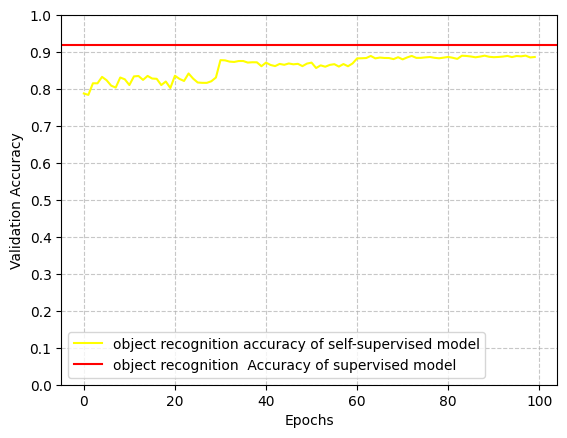

In [33]:

plt.plot(valid_acc_block4_with_featuremap2,label ='object recognition accuracy of self-supervised model' ,color = 'yellow')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epochs')
plt.yticks(np.arange(0.0, 1.1, 0.1))

# Add a horizontal red line at y=0.919
plt.axhline(y=0.919, color='red', linestyle='-', label='object recognition  Accuracy of supervised model')

# Show legend
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
# Display the plot
plt.show()

**based on this, test the effect of amount label**

In [34]:
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np

class CIFAR10CustomDataset(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False, samples_per_class=None):
        self.cifar10 = CIFAR10(root, train=train, transform=transform, target_transform=target_transform, download=download)
        self.samples_per_class = samples_per_class
        self.selected_indices = self.select_samples()

    def __getitem__(self, index):
        original_index = self.selected_indices[index]
        img, target = self.cifar10[original_index]
        return img, target

    def __len__(self):
        return len(self.selected_indices)

    def select_samples(self):
        class_indices = [[] for _ in range(len(self.cifar10.classes))]

        # Collect indices for each class
        for i, (_, target) in enumerate(self.cifar10):
            class_indices[target].append(i)

        selected_indices = []

        # Randomly select samples for each class
        for indices in class_indices:
            if self.samples_per_class is not None:
                selected_indices.extend(np.random.choice(indices, size=self.samples_per_class, replace=False))
            else:
                selected_indices.extend(indices)

        return selected_indices

k=1000

In [35]:
transform = transforms.Compose([
    transforms.RandomCrop(size = 32, padding=4),#random cropping
    transforms.RandomHorizontalFlip() ,#random flip
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

samples_per_class = {'airplane': 1000, 'automobile': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000,
                     'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000}

# Create a custom dataset
cifar10_1000 = CIFAR10CustomDataset(root='./data', train=True, transform=transform, download=True, samples_per_class=samples_per_class['airplane'])

# Create a DataLoader for the custom dataset
dataloader_1000 = DataLoader(cifar10_1000, batch_size=128, shuffle=True)

Files already downloaded and verified


In [37]:
#Conv-3 + 2nd block feature map
out_feat_keys = ['conv2']
classifier = Classifier({'num_classes': 10, 'nChannels': 192, 'cls_type': 'NIN_ConvBlock3'}).to(device)
#hyperparameter setting
INITIAL_LR = 0.1
MOMENTUM = 0.9
REG = 5e-4
EPOCHS = 100
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(classifier.parameters(), lr = INITIAL_LR,
                      momentum = MOMENTUM,
                      weight_decay=REG)

In [38]:
# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

DECAY = 0.2
valid_acc_block4_with_featuremap2_k1000 = []
losslist = []
print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    if i  == 30 or i == 60 or i == 80:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)

    classifier.train()

    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0
    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(dataloader_1000):
        ####################################

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # inputs = inputs.to(device)
        inputs = inputs.to(device)
        NIN_net_4block = NIN_net_4block.to(device)
        feature_map = NIN_net_4block(inputs, out_feat_keys=out_feat_keys)
        targets = targets.to(device)

        # compute the output and loss
        outputs = classifier(feature_map)
        loss = criterion(outputs, targets)

        train_loss += loss
        # zero the gradient

        optimizer.zero_grad()
        # backpropagation

        loss.backward()
        # apply gradient and update the weights
        optimizer.step()
        # count the number of correctly predicted samples in the current batch
        _, predicted = outputs.max(1)  #make prediction based on the highest value
        total_examples += targets.size(0) # in this case,128 for each batch
        correct_examples += predicted.eq(targets).sum().item()
        ####################################

    avg_loss = train_loss / len(dataloader_1000)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))


    classifier.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            inputs = inputs.to(device)
            targets = targets.to(device)
            feature_map = NIN_net_4block(inputs, out_feat_keys=out_feat_keys)
            NIN_net_4block = NIN_net_4block.to(device)


            # compute the output and loss

            outputs = classifier(feature_map)
            loss = criterion(outputs, targets)
            val_loss += loss

            # count the number of correctly predicted samples in the current batch
            _, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += predicted.eq(targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    valid_acc_block4_with_featuremap2_k1000.append(avg_acc)
    losslist.append(avg_loss.item())
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")

        torch.save(classifier.state_dict(), 'classifier_conv3_NIN_with_featuremap2_k1000.pth')

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 1.0727, Training accuracy: 0.6300
Validation loss: 1.1432, Validation accuracy: 0.6209

Epoch 1:
Training loss: 0.7129, Training accuracy: 0.7544
Validation loss: 0.8819, Validation accuracy: 0.6934

Epoch 2:
Training loss: 0.6088, Training accuracy: 0.7880
Validation loss: 0.7670, Validation accuracy: 0.7349

Epoch 3:
Training loss: 0.5581, Training accuracy: 0.8034
Validation loss: 0.6889, Validation accuracy: 0.7591

Epoch 4:
Training loss: 0.5270, Training accuracy: 0.8167
Validation loss: 0.6650, Validation accuracy: 0.7677

Epoch 5:
Training loss: 0.4652, Training accuracy: 0.8408
Validation loss: 0.6417, Validation accuracy: 0.7834

Epoch 6:
Training loss: 0.4569, Training accuracy: 0.8418
Validation loss: 0.6900, Validation accuracy: 0.7724

Epoch 7:
Training loss: 0.4371, Training accuracy: 0.8495
Validation loss: 0.6969, Validation accuracy: 0.7571

Epoch 8:
Training loss: 0.4331, Training accuracy: 0.8511
Validation loss: 0.7239, 

k=400

In [39]:
transform = transforms.Compose([
    transforms.RandomCrop(size = 32, padding=4),#random cropping
    transforms.RandomHorizontalFlip() ,#random flip
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

samples_per_class = {'airplane': 400, 'automobile': 400, 'bird': 400, 'cat': 400, 'deer': 400, 'dog': 400,
                     'frog': 400, 'horse': 400, 'ship': 400, 'truck': 400}

# Create a custom dataset
cifar10_400 = CIFAR10CustomDataset(root='./data', train=True, transform=transform, download=True, samples_per_class=samples_per_class['airplane'])

# Create a DataLoader for the custom dataset
dataloader_400 = DataLoader(cifar10_400, batch_size=128, shuffle=True)

Files already downloaded and verified


In [40]:
#Conv-3 + 2nd block feature map with k400
out_feat_keys = ['conv2']
classifier = Classifier({'num_classes': 10, 'nChannels': 192, 'cls_type': 'NIN_ConvBlock3'}).to(device)
#hyperparameter setting
INITIAL_LR = 0.1
MOMENTUM = 0.9
REG = 5e-4
EPOCHS = 100
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(classifier.parameters(), lr = INITIAL_LR,
                      momentum = MOMENTUM,
                      weight_decay=REG)

In [41]:
# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

DECAY = 0.2
valid_acc_block4_with_featuremap2_k400 = []
losslist = []
print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    if i  == 30 or i == 60 or i == 80:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)

    classifier.train()

    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0
    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(dataloader_400):
        ####################################

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # inputs = inputs.to(device)
        inputs = inputs.to(device)
        NIN_net_4block = NIN_net_4block.to(device)
        feature_map = NIN_net_4block(inputs, out_feat_keys=out_feat_keys)
        targets = targets.to(device)

        # compute the output and loss
        outputs = classifier(feature_map)
        loss = criterion(outputs, targets)

        train_loss += loss
        # zero the gradient

        optimizer.zero_grad()
        # backpropagation

        loss.backward()
        # apply gradient and update the weights
        optimizer.step()
        # count the number of correctly predicted samples in the current batch
        _, predicted = outputs.max(1)  #make prediction based on the highest value
        total_examples += targets.size(0) # in this case,128 for each batch
        correct_examples += predicted.eq(targets).sum().item()
        ####################################

    avg_loss = train_loss / len(dataloader_400)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))


    classifier.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            inputs = inputs.to(device)
            targets = targets.to(device)
            feature_map = NIN_net_4block(inputs, out_feat_keys=out_feat_keys)
            NIN_net_4block = NIN_net_4block.to(device)


            # compute the output and loss

            outputs = classifier(feature_map)
            loss = criterion(outputs, targets)
            val_loss += loss

            # count the number of correctly predicted samples in the current batch
            _, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += predicted.eq(targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    valid_acc_block4_with_featuremap2_k400.append(avg_acc)
    losslist.append(avg_loss.item())
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")

        torch.save(classifier.state_dict(), 'classifier_conv3_NIN_with_featuremap2_k400.pth')

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 1.6727, Training accuracy: 0.5135
Validation loss: 1.6525, Validation accuracy: 0.4276

Epoch 1:
Training loss: 0.8775, Training accuracy: 0.7057
Validation loss: 1.0168, Validation accuracy: 0.6520

Epoch 2:
Training loss: 0.7564, Training accuracy: 0.7385
Validation loss: 0.8177, Validation accuracy: 0.7205

Epoch 3:
Training loss: 0.6570, Training accuracy: 0.7772
Validation loss: 0.8419, Validation accuracy: 0.7105

Epoch 4:
Training loss: 0.5944, Training accuracy: 0.7917
Validation loss: 0.8072, Validation accuracy: 0.7249

Epoch 5:
Training loss: 0.5596, Training accuracy: 0.8087
Validation loss: 0.7416, Validation accuracy: 0.7467

Epoch 6:
Training loss: 0.5038, Training accuracy: 0.8273
Validation loss: 0.7634, Validation accuracy: 0.7409

Epoch 7:
Training loss: 0.4598, Training accuracy: 0.8347
Validation loss: 0.8634, Validation accuracy: 0.7077

Epoch 8:
Training loss: 0.4312, Training accuracy: 0.8572
Validation loss: 0.7494, 

k=100

In [42]:
transform = transforms.Compose([
    transforms.RandomCrop(size = 32, padding=4),#random cropping
    transforms.RandomHorizontalFlip() ,#random flip
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

samples_per_class = {'airplane': 100, 'automobile': 100, 'bird': 100, 'cat': 100, 'deer': 100, 'dog': 100,
                     'frog': 100, 'horse': 100, 'ship': 100, 'truck': 100}

# Create a custom dataset
cifar10_100 = CIFAR10CustomDataset(root='./data', train=True, transform=transform, download=True, samples_per_class=samples_per_class['airplane'])

# Create a DataLoader for the custom dataset
dataloader_100 = DataLoader(cifar10_100, batch_size=128, shuffle=True)

Files already downloaded and verified


In [43]:
#Conv-3 + 2nd block feature map with k100
out_feat_keys = ['conv2']
classifier = Classifier({'num_classes': 10, 'nChannels': 192, 'cls_type': 'NIN_ConvBlock3'}).to(device)
#hyperparameter setting
INITIAL_LR = 0.1
MOMENTUM = 0.9
REG = 5e-4
EPOCHS = 100
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(classifier.parameters(), lr = INITIAL_LR,
                      momentum = MOMENTUM,
                      weight_decay=REG)

In [44]:
# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

DECAY = 0.2
valid_acc_block4_with_featuremap2_k100 = []
losslist = []
print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    if i  == 30 or i == 60 or i == 80:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)

    classifier.train()

    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0
    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(dataloader_100):
        ####################################

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # inputs = inputs.to(device)
        inputs = inputs.to(device)
        NIN_net_4block = NIN_net_4block.to(device)
        feature_map = NIN_net_4block(inputs, out_feat_keys=out_feat_keys)
        targets = targets.to(device)

        # compute the output and loss
        outputs = classifier(feature_map)
        loss = criterion(outputs, targets)

        train_loss += loss
        # zero the gradient

        optimizer.zero_grad()
        # backpropagation

        loss.backward()
        # apply gradient and update the weights
        optimizer.step()
        # count the number of correctly predicted samples in the current batch
        _, predicted = outputs.max(1)  #make prediction based on the highest value
        total_examples += targets.size(0) # in this case,128 for each batch
        correct_examples += predicted.eq(targets).sum().item()
        ####################################

    avg_loss = train_loss / len(dataloader_100)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))


    classifier.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            inputs = inputs.to(device)
            targets = targets.to(device)
            feature_map = NIN_net_4block(inputs, out_feat_keys=out_feat_keys)
            NIN_net_4block = NIN_net_4block.to(device)


            # compute the output and loss

            outputs = classifier(feature_map)
            loss = criterion(outputs, targets)
            val_loss += loss

            # count the number of correctly predicted samples in the current batch
            _, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += predicted.eq(targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    valid_acc_block4_with_featuremap2_k100.append(avg_acc)
    losslist.append(avg_loss.item())
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")

        torch.save(classifier.state_dict(), 'classifier_conv3_NIN_with_featuremap2_k100.pth')

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 2.3207, Training accuracy: 0.3590
Validation loss: 3.1070, Validation accuracy: 0.1000

Epoch 1:
Training loss: 1.2600, Training accuracy: 0.6060
Validation loss: 2.5582, Validation accuracy: 0.2579

Epoch 2:
Training loss: 0.9476, Training accuracy: 0.6620
Validation loss: 2.4446, Validation accuracy: 0.3320

Epoch 3:
Training loss: 0.7019, Training accuracy: 0.7450
Validation loss: 2.1296, Validation accuracy: 0.3663

Epoch 4:
Training loss: 0.5802, Training accuracy: 0.8000
Validation loss: 1.7692, Validation accuracy: 0.4539

Epoch 5:
Training loss: 0.4925, Training accuracy: 0.8280
Validation loss: 1.3422, Validation accuracy: 0.5531

Epoch 6:
Training loss: 0.4399, Training accuracy: 0.8490
Validation loss: 1.0483, Validation accuracy: 0.6438

Epoch 7:
Training loss: 0.3901, Training accuracy: 0.8700
Validation loss: 0.9482, Validation accuracy: 0.6713

Epoch 8:
Training loss: 0.3392, Training accuracy: 0.8930
Validation loss: 0.9283, 

k = 20

In [45]:
transform = transforms.Compose([
    transforms.RandomCrop(size = 32, padding=4),#random cropping
    transforms.RandomHorizontalFlip() ,#random flip
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

samples_per_class = {'airplane': 20, 'automobile': 20, 'bird': 20, 'cat': 20, 'deer': 20, 'dog': 20,
                     'frog': 20, 'horse': 20, 'ship': 20, 'truck': 20}

# Create a custom dataset
cifar10_20 = CIFAR10CustomDataset(root='./data', train=True, transform=transform, download=True, samples_per_class=samples_per_class['airplane'])

# Create a DataLoader for the custom dataset
dataloader_20 = DataLoader(cifar10_20, batch_size=128, shuffle=True)

Files already downloaded and verified


In [46]:
#Conv-3 + 2nd block feature map with k20
out_feat_keys = ['conv2']
classifier = Classifier({'num_classes': 10, 'nChannels': 192, 'cls_type': 'NIN_ConvBlock3'}).to(device)
#hyperparameter setting
INITIAL_LR = 0.1
MOMENTUM = 0.9
REG = 5e-4
EPOCHS = 100
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(classifier.parameters(), lr = INITIAL_LR,
                      momentum = MOMENTUM,
                      weight_decay=REG)

In [47]:
# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

DECAY = 0.2
valid_acc_block4_with_featuremap2_k20 = []
losslist = []
print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    if i  == 30 or i == 60 or i == 80:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)

    classifier.train()

    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0
    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(dataloader_20):
        ####################################

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # inputs = inputs.to(device)
        inputs = inputs.to(device)
        NIN_net_4block = NIN_net_4block.to(device)
        feature_map = NIN_net_4block(inputs, out_feat_keys=out_feat_keys)
        targets = targets.to(device)

        # compute the output and loss
        outputs = classifier(feature_map)
        loss = criterion(outputs, targets)

        train_loss += loss
        # zero the gradient

        optimizer.zero_grad()
        # backpropagation

        loss.backward()
        # apply gradient and update the weights
        optimizer.step()
        # count the number of correctly predicted samples in the current batch
        _, predicted = outputs.max(1)  #make prediction based on the highest value
        total_examples += targets.size(0) # in this case,128 for each batch
        correct_examples += predicted.eq(targets).sum().item()
        ####################################

    avg_loss = train_loss / len(dataloader_20)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))


    classifier.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            inputs = inputs.to(device)
            targets = targets.to(device)
            feature_map = NIN_net_4block(inputs, out_feat_keys=out_feat_keys)
            NIN_net_4block = NIN_net_4block.to(device)


            # compute the output and loss

            outputs = classifier(feature_map)
            loss = criterion(outputs, targets)
            val_loss += loss

            # count the number of correctly predicted samples in the current batch
            _, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += predicted.eq(targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    valid_acc_block4_with_featuremap2_k20.append(avg_acc)
    losslist.append(avg_loss.item())
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")

        torch.save(classifier.state_dict(), 'classifier_conv3_NIN_with_featuremap2_k20.pth')

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 3.1175, Training accuracy: 0.1300
Validation loss: 2.3592, Validation accuracy: 0.1678

Epoch 1:
Training loss: 1.4704, Training accuracy: 0.5500
Validation loss: 2.5421, Validation accuracy: 0.1000

Epoch 2:
Training loss: 1.1630, Training accuracy: 0.6500
Validation loss: 2.8609, Validation accuracy: 0.1000

Epoch 3:
Training loss: 0.9320, Training accuracy: 0.7200
Validation loss: 3.2419, Validation accuracy: 0.1000

Epoch 4:
Training loss: 0.6587, Training accuracy: 0.8000
Validation loss: 3.3983, Validation accuracy: 0.1000

Epoch 5:
Training loss: 0.4423, Training accuracy: 0.8450
Validation loss: 3.5012, Validation accuracy: 0.1000

Epoch 6:
Training loss: 0.3489, Training accuracy: 0.9150
Validation loss: 3.5918, Validation accuracy: 0.1002

Epoch 7:
Training loss: 0.3245, Training accuracy: 0.9100
Validation loss: 3.6828, Validation accuracy: 0.1031

Epoch 8:
Training loss: 0.2249, Training accuracy: 0.9300
Validation loss: 3.6115, 

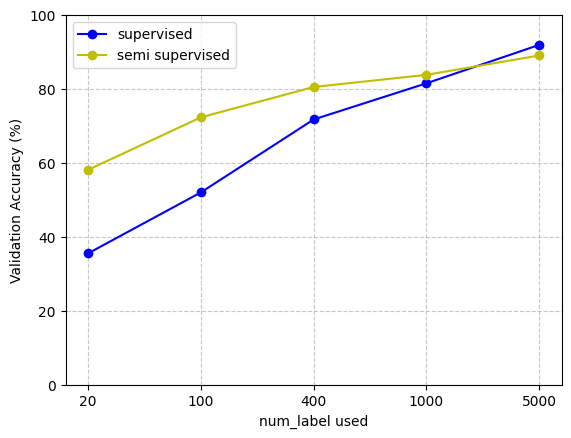

In [51]:
import matplotlib.pyplot as plt

# Data
categories = ['20', '100', '400', '1000', '5000']
accuracy_values_supervised = [35.52, 52.00, 71.73, 81.51, 91.9]
accuracy_values_selfsupervised = [58.12, 72.31, 80.52, 83.8, 89.04]

# Plotting
plt.plot(categories, accuracy_values_supervised,  marker='o', linestyle='-', color='b', label='supervised')
plt.plot(categories, accuracy_values_selfsupervised,  marker='o', linestyle='-', color='y', label='semi supervised')
# Adding labels and title
plt.xlabel('num_label used')
plt.ylabel('Validation Accuracy (%)')
plt.ylim(0, 100)  # Set y-axis limit to 0-100%


# Display the plot
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


**finetune the whole model**

feature map + classifier

In [69]:
import torch.nn as nn
import torch.optim as optim

# Assuming you have NIN_net_4block and classifier models
NIN_net_4block = NetworkInNetwork({'num_classes': 4, 'num_stages': 4, 'use_avg_on_conv3': False})
# Load the state_dict using torch.load
checkpoint_path = '/content/NIN_net_4block.pth'
checkpoint = torch.load(checkpoint_path)

# Load the state_dict into the model
NIN_net_4block.load_state_dict(checkpoint)

classifier = Classifier({'num_classes': 10, 'nChannels': 192, 'cls_type': 'NIN_ConvBlock3'}).to(device)

# Extract the first two blocks from NIN_net_4block
nin_blocks = nn.Sequential(
    NIN_net_4block._feature_blocks[0],
    NIN_net_4block._feature_blocks[1]
)

# Combine the first two blocks from NIN_net_4block and the classifier
combined_model = nn.Sequential(
    nin_blocks,
    classifier
)

#hyperparameter setting
INITIAL_LR = 0.1
MOMENTUM = 0.9
REG = 5e-4
EPOCHS = 100
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(combined_model.parameters(), lr = INITIAL_LR,
                      momentum = MOMENTUM,
                      weight_decay=REG)


In [73]:
# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

DECAY = 0.2
valid_acc_finetune = []
losslist = []
print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    if i  == 30 or i == 60 or i == 80:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)

    combined_model.train()

    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0
    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # inputs = inputs.to(device)
        inputs = inputs.to(device)
        combined_model = combined_model.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = combined_model(inputs)
        loss = criterion(outputs, targets)

        train_loss += loss
        # zero the gradient

        optimizer.zero_grad()
        # backpropagation

        loss.backward()
        # apply gradient and update the weights
        optimizer.step()
        # count the number of correctly predicted samples in the current batch
        _, predicted = outputs.max(1)  #make prediction based on the highest value
        total_examples += targets.size(0) # in this case,128 for each batch
        correct_examples += predicted.eq(targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))


    combined_model.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            inputs = inputs.to(device)
            targets = targets.to(device)
            # compute the output and loss

            outputs = combined_model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss

            # count the number of correctly predicted samples in the current batch
            _, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += predicted.eq(targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    valid_acc_finetune.append(avg_acc)
    losslist.append(avg_loss.item())
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")

        torch.save(classifier.state_dict(), 'classifier_finetune.pth')

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 1.4899, Training accuracy: 0.4654
Validation loss: 1.5715, Validation accuracy: 0.4447

Epoch 1:
Training loss: 1.0259, Training accuracy: 0.6376
Validation loss: 1.7177, Validation accuracy: 0.4708

Epoch 2:
Training loss: 0.8615, Training accuracy: 0.6979
Validation loss: 0.8769, Validation accuracy: 0.6927

Epoch 3:
Training loss: 0.7692, Training accuracy: 0.7314
Validation loss: 1.1552, Validation accuracy: 0.6134

Epoch 4:
Training loss: 0.7226, Training accuracy: 0.7503
Validation loss: 0.9085, Validation accuracy: 0.6911

Epoch 5:
Training loss: 0.6826, Training accuracy: 0.7625
Validation loss: 0.8907, Validation accuracy: 0.7068

Epoch 6:
Training loss: 0.6506, Training accuracy: 0.7760
Validation loss: 1.3859, Validation accuracy: 0.5809

Epoch 7:
Training loss: 0.6362, Training accuracy: 0.7799
Validation loss: 1.1080, Validation accuracy: 0.6429

Epoch 8:
Training loss: 0.6168, Training accuracy: 0.7874
Validation loss: 0.8460, 